Importación de Librerías y Carga de Datos

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from folium.plugins import HeatMap

# Módulos Modelo y Controlador están en la misma carpeta que este notebook
import Modelo
from Controlador import *

# Carga de datos
df_mercado_inmobiliario = Modelo.obtener_datos_api(Modelo.url_mercado_inmobiliario)
df_espacio_publico = Modelo.obtener_datos_api(Modelo.url_espacio_publico)
df_inmuebles_venta = Modelo.obtener_datos_api(Modelo.url_inmuebles_venta)
df_inmuebles_bogota = pd.read_csv('./data/inmuebles_bogota.csv')
df_plan_estrategico = Modelo.obtener_datos_api(Modelo.url_plan_estrategico)
df_georeferencia_localidad = Modelo.obtener_datos_api(Modelo.url_georeferencia_localidad)

Exploración de Datos

Limpieza de Datos y Preprocesamiento General

In [2]:
#Llamando funciones del Controlador
df_mercado_inmobiliario_limpio = limpiar_transformar_mercado_inmobiliario(df_mercado_inmobiliario)
df_espacio_publico_limpio = limpiar_transformar_espacio_publico(df_espacio_publico)
df_inmuebles_venta_limpio = limpiar_transformar_inmuebles_venta(df_inmuebles_venta)
df_inmuebles_bogota_limpio = limpiar_transformar_inmuebles_bogota(df_inmuebles_bogota)
df_plan_estrategico_limpio = limpiar_transformar_plan_estrategico(df_plan_estrategico)
df_georeferencia_localidad_limpio = limpiar_transformar_georeferencia_localidad(df_georeferencia_localidad)


In [3]:
# Visualizacion de df luego de la limpieza
print(df_mercado_inmobiliario_limpio.head())
print(df_espacio_publico_limpio.head())
print(df_inmuebles_venta_limpio.head())
print(df_inmuebles_bogota_limpio.head())
print(df_plan_estrategico_limpio.head())
print(df_georeferencia_localidad_limpio.head())

                                                help  success  \
0  https://datosabiertos.bogota.gov.co/api/3/acti...     True   
1  https://datosabiertos.bogota.gov.co/api/3/acti...     True   
2  https://datosabiertos.bogota.gov.co/api/3/acti...     True   
3  https://datosabiertos.bogota.gov.co/api/3/acti...     True   
4  https://datosabiertos.bogota.gov.co/api/3/acti...     True   

                                              result  
0  {'start': '/api/3/action/datastore_search?q=ti...  
1  [{'type': 'int', 'id': '_id'}, {'type': 'text'...  
2                                               True  
3                                                  5  
4                                        title:jones  
                tipo_de_espacio codigo_upz  espacio_en_m2  poblacion
0  01 Paseo de los Libertadores       UPZ1            802       2189
1                   10 La Uribe      UPZ10             13      30098
2                  100 Galerias     UPZ100              2      32624
3  

Accesibilidad y Calidad de Vida: ¿Cuáles zonas ofrecen la mejor combinación de accesibilidad a espacios verdes y precios asequibles de inmuebles?

Limpieza y Preprocesamiento

In [4]:
# Limpieza y extraccion de barrios y localidades en df_inmuebles_bogota
def extraer_barrios_localidad(upz):
    upz = str(upz)
    if ':' in upz:
        localidad, barrios = upz.split(':')
        barrios_lista = [b.strip() for b in barrios.split('+')]
        return localidad.strip(), barrios_lista
    else:
        # Si no hay ":", impacto a unsolo barrio
        return upz.strip(), [upz.strip()]

# Recorrecos cada fila y creamos una nueva columna 'localidad_barrios'
df_inmuebles_bogota_limpio['localidad_barrios'] = df_inmuebles_bogota_limpio['UPZ'].apply(extraer_barrios_localidad)

# Separacion de'localidad' y 'barrios'
df_inmuebles_bogota_limpio[['localidad', 'barrios']] = pd.DataFrame(df_inmuebles_bogota_limpio['localidad_barrios'].tolist(), index=df_inmuebles_bogota_limpio.index)
# Borramos digitos del codigo upz
df_espacio_publico_limpio['upz'] = df_espacio_publico_limpio['tipo_de_espacio'].str.extract(r'(\D+)')
df_espacio_publico_limpio['upz'] = df_espacio_publico_limpio['upz'].str.strip()




In [5]:
def expandir_barrios(row):
    # Extraccion de los barrios y otros campos cuando un predio afecta mas de un barrio
    barrios = row['barrios']
    valor = row['Valor']
    num_barrios = len(barrios)
    valor_dividido = valor / num_barrios

    # Almacenamos las nuevas filas
    nuevas_filas = []
    for barrio in barrios:
        nueva_fila = row.copy()
        nueva_fila['upz'] = barrio
        nueva_fila['valor_ajustado'] = valor_dividido
        nueva_fila['num_barrios_afectados'] = num_barrios
        nuevas_filas.append(nueva_fila)
    return nuevas_filas

# Expandimos el DataFrame
df_expandido = pd.DataFrame([fila for _, row in df_inmuebles_bogota_limpio.iterrows() 
                             for fila in expandir_barrios(row)])

Pregunta 1: Unión de los DataFrames

In [6]:
# Unimos: df_inmuebles_bogota_limpio y df_espacio_publico_limpio
df_combinado_primero = pd.merge(df_expandido, df_espacio_publico_limpio, on='upz', how='left')

# Unimos: df_combinado_primero con df_georeferencia_localidad_limpio
df_combinado_final = pd.merge(df_combinado_primero, df_georeferencia_localidad_limpio, on='localidad', how='left')

# Mostrarmos las primeras filas para verificar
print(df_combinado_final.head())

          Tipo                                 Descripcion  Habitaciones  \
0  Apartamento  Apartamento en venta en Zona Noroccidental             3   
1  Apartamento  Apartamento en venta en Zona Noroccidental             3   
2         Casa                   Casa en venta en Castilla             4   
3         Casa                   Casa en venta en Castilla             4   
4  Apartamento     Apartamento en venta en Chico Reservado             3   

   Baños  Área              Barrio                                 UPZ  \
0      2    70  Zona Noroccidental  CHAPINERO: Pardo Rubio + Chapinero   
1      2    70  Zona Noroccidental  CHAPINERO: Pardo Rubio + Chapinero   
2      3   170            Castilla         KENNEDY: Castilla + Bavaria   
3      3   170            Castilla         KENNEDY: Castilla + Bavaria   
4      3   144     Chico Reservado  CHAPINERO: Chico Lago + El Refugio   

        Valor                      localidad_barrios  localidad  \
0   360000000  (CHAPINERO, [Par

In [7]:
# Dividimos el conjunto de datos en un 70% para entrenamiento y un 30% para prueba
df_entrenamiento, df_prueba = train_test_split(df_combinado_final, test_size=0.3, random_state=42)

# Observamos la calidad
print("Conjunto de Entrenamiento:")
print(df_entrenamiento.describe())

# Observamos la calidad
print("\nConjunto de Prueba:")
print(df_prueba.describe())

Conjunto de Entrenamiento:
       Habitaciones        Baños           Área         Valor  valor_ajustado  \
count   8974.000000  8974.000000    8974.000000  8.974000e+03    8.974000e+03   
mean       3.013706     2.490974     151.970247  4.629574e+08    3.339515e+08   
std        1.759384     1.262440    1788.211372  5.361578e+08    3.830940e+08   
min        1.000000     0.000000       2.000000 -2.144967e+09   -2.094967e+09   
25%        2.000000     2.000000      58.000000  2.432500e+08    1.650000e+08   
50%        3.000000     2.000000      82.000000  4.000000e+08    2.880000e+08   
75%        3.000000     3.000000     140.000000  6.500000e+08    4.750000e+08   
max       32.000000     9.000000  166243.000000  2.133000e+09    2.101242e+09   

       num_barrios_afectados  espacio_en_m2      poblacion     longitud  \
count            8974.000000    8326.000000    8326.000000  4508.000000   
mean                1.534544     211.209344   58667.833774   -74.054679   
std               

In [8]:
#manejo de valores atipicos
q1 = df_entrenamiento['Valor'].quantile(0.25)
q3 = df_entrenamiento['Valor'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filtro de valores atipicos
df_filtrado = df_entrenamiento[(df_entrenamiento['Valor'] >= lower_bound) & 
                                         (df_entrenamiento['Valor'] <= upper_bound)]

# Eliminando valores negativos
df_filtrado = df_filtrado[df_filtrado['Valor'] >= 0]

In [9]:
print(df_filtrado.head())
# Exploracion de los datos de espacio público y precios de inmuebles
print(df_filtrado[['espacio_en_m2', 'valor_ajustado', 'Área']].describe())

              Tipo                          Descripcion  Habitaciones  Baños  \
7019   Apartamento    Apartamento en venta en Chapinero             1      1   
6321   Apartamento  Apartamento en venta en Bella Suiza             2      3   
8624          Casa      Casa en venta en Barrios Unidos             3      3   
2188   Apartamento     Apartamento en venta en El Batán             2      2   
11358  Apartamento    Apartamento en venta en Chapinero             1      1   

       Área          Barrio                                    UPZ      Valor  \
7019     42       Chapinero     CHAPINERO: Pardo Rubio + Chapinero  410000000   
6321     85     Bella Suiza  USAQUEN: Country Club + Santa Barbara  699927000   
8624    210  Barrios Unidos                              Los Andes  430000000   
2188     91        El Batán                            La Alhambra  445000000   
11358    49       Chapinero     CHAPINERO: Pardo Rubio + Chapinero  340200000   

                              lo

In [10]:
def generar_diccionario_datos(df):
    diccionario = {}
    for columna in df.columns:
        datos_columna = df[columna]
        tipo_dato = datos_columna.dtype
        ejemplo_dato = datos_columna.iloc[0]
        diccionario[columna] = {'Tipo de Dato': tipo_dato, 'Ejemplo de Dato': ejemplo_dato}
    return diccionario

# Genera diccionarios para cada DataFrame y los muestra
dicc_mercado_inmobiliario = generar_diccionario_datos(df_mercado_inmobiliario_limpio)
dicc_espacio_publico = generar_diccionario_datos(df_espacio_publico_limpio)
dicc_inmuebles_venta = generar_diccionario_datos(df_inmuebles_venta_limpio)
dicc_inmuebles_bogota = generar_diccionario_datos(df_inmuebles_bogota_limpio)
dicc_plan_estrategico = generar_diccionario_datos(df_plan_estrategico_limpio)
dicc_georeferencia_localidad = generar_diccionario_datos(df_georeferencia_localidad_limpio)

#print("Diccionario Mercado Inmobiliario:\n", dicc_mercado_inmobiliario)
#print("\nDiccionario Plan Estrategico:\n",dicc_plan_estrategico)
#print("\nDiccionario Inmuebles Venta:\n", dicc_inmuebles_venta)
print("Diccionario Espacio Público:\n", dicc_espacio_publico)
print("\nDiccionario Inmuebles Bogotá:\n", dicc_inmuebles_bogota)
print("\nDiccionario Georeferencia Localidades:\n",dicc_georeferencia_localidad)

Diccionario Espacio Público:
 {'tipo_de_espacio': {'Tipo de Dato': dtype('O'), 'Ejemplo de Dato': '01 Paseo de los Libertadores'}, 'codigo_upz': {'Tipo de Dato': dtype('O'), 'Ejemplo de Dato': 'UPZ1'}, 'espacio_en_m2': {'Tipo de Dato': dtype('int32'), 'Ejemplo de Dato': 802}, 'poblacion': {'Tipo de Dato': dtype('int32'), 'Ejemplo de Dato': 2189}, 'upz': {'Tipo de Dato': dtype('O'), 'Ejemplo de Dato': 'Paseo de los Libertadores'}}

Diccionario Inmuebles Bogotá:
 {'Tipo': {'Tipo de Dato': dtype('O'), 'Ejemplo de Dato': 'Apartamento'}, 'Descripcion': {'Tipo de Dato': dtype('O'), 'Ejemplo de Dato': 'Apartamento en venta en Zona Noroccidental'}, 'Habitaciones': {'Tipo de Dato': dtype('int32'), 'Ejemplo de Dato': 3}, 'Baños': {'Tipo de Dato': dtype('int32'), 'Ejemplo de Dato': 2}, 'Área': {'Tipo de Dato': dtype('int32'), 'Ejemplo de Dato': 70}, 'Barrio': {'Tipo de Dato': dtype('O'), 'Ejemplo de Dato': 'Zona Noroccidental'}, 'UPZ': {'Tipo de Dato': dtype('O'), 'Ejemplo de Dato': 'CHAPINERO: P

Análisis Estadístico y Visualización

In [11]:
# Calculo de promedios
promedio_espacio = df_filtrado['espacio_en_m2'].mean()
promedio_precio = df_filtrado['Valor'].mean()
promedio_area = df_filtrado['Área'].mean()

# Filtrando zonas que superan el promedio de espacio público, tienen precios por debajo del promedio y un area razonable
zonas_optimas_con_area = df_filtrado[(df_filtrado['espacio_en_m2'] > promedio_espacio) & 
                                     (df_filtrado['Valor'] < promedio_precio) & 
                                     (df_filtrado['Área'] >= promedio_area * 0.75)]  # Área al menos el 75% del promedio

# Mostrar las zonas optimas
print(zonas_optimas_con_area[['upz', 'espacio_en_m2', 'Valor', 'Área']].drop_duplicates())

               upz  espacio_en_m2      Valor  Área
6779   La Academia         1138.0  350000000   120
332      Guaymaral          282.0  389000000   105
12118    Guaymaral          282.0  370000000   120
2689   La Academia         1138.0  425000000   190
12117  La Academia         1138.0  370000000   120
3497     Guaymaral          282.0  350000000   120
2690     Guaymaral          282.0  425000000   190
1588   El Mochuelo        21960.0  220000000   113
331    La Academia         1138.0  389000000   105
12398  El Mochuelo        21960.0  265000000   144


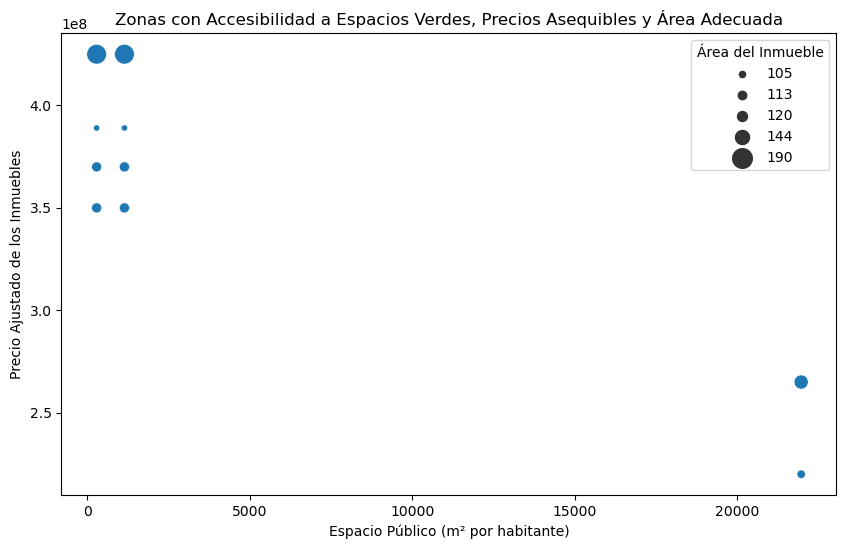

In [12]:
# Relacion entre el espacio publico por habitante, el Valor de los inmuebles y el area de los inmuebles en zonas que cumplen ciertos criterios de accesibilidad y precio asequible.
plt.figure(figsize=(10, 6))
sns.scatterplot(data=zonas_optimas_con_area, x='espacio_en_m2', y='Valor', size='Área', sizes=(20, 200))
plt.title('Zonas con Accesibilidad a Espacios Verdes, Precios Asequibles y Área Adecuada')
plt.xlabel('Espacio Público (m² por habitante)')
plt.ylabel('Precio Ajustado de los Inmuebles')
plt.legend(title='Área del Inmueble')
plt.show()

c:\Users\RTOFA2\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\RTOFA2\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\RTOFA2\AppData\Local\Temp\ipykernel_25908\3401711729.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zonas_optimas_con_area['cluster'] = kmeans.fit_pr

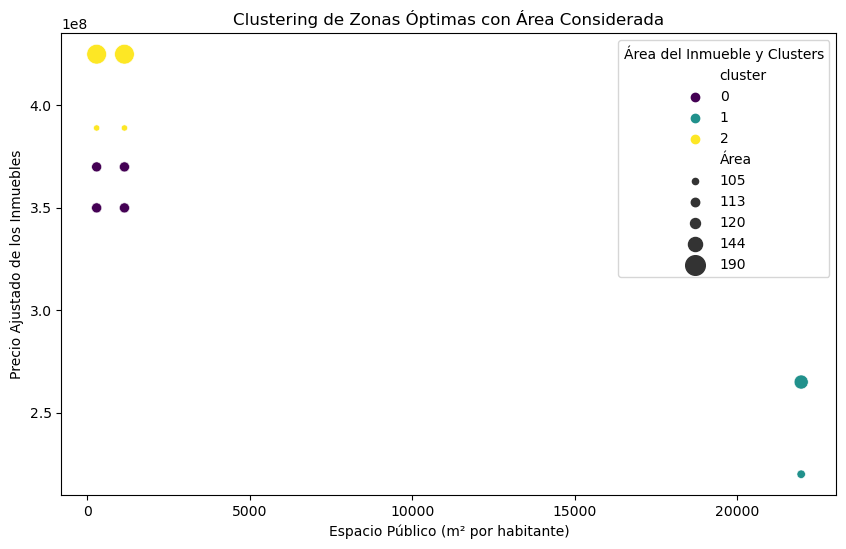

In [22]:
# Aplicación de KMeans considerando tambien el area
kmeans = KMeans(n_clusters=3, random_state=42)
zonas_optimas_con_area['cluster'] = kmeans.fit_predict(zonas_optimas_con_area[['espacio_en_m2', 'Valor', 'Área']])

# Visualizacion de clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=zonas_optimas_con_area, x='espacio_en_m2', y='Valor', hue='cluster', size='Área', sizes=(20, 200), palette='viridis')
plt.title('Clustering de Zonas Óptimas con Área Considerada')
plt.xlabel('Espacio Público (m² por habitante)')
plt.ylabel('Precio Ajustado de los Inmuebles')
plt.legend(title='Área del Inmueble y Clusters')
plt.show()

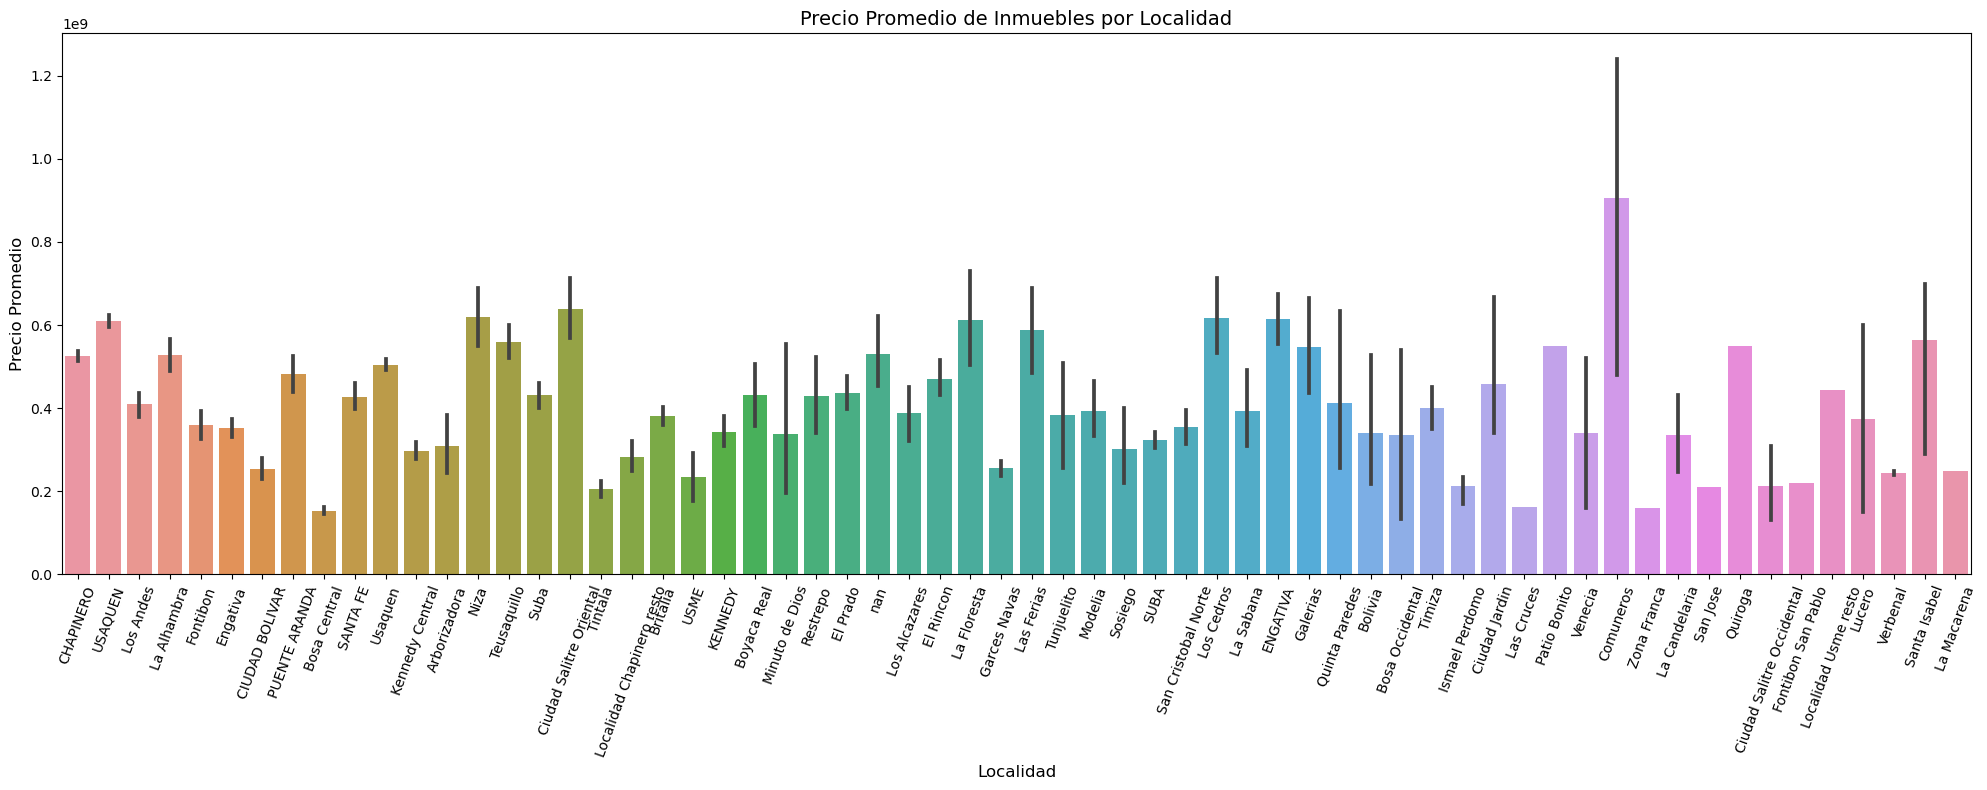

c:\Users\RTOFA2\AppData\Local\anaconda3\Lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
c:\Users\RTOFA2\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


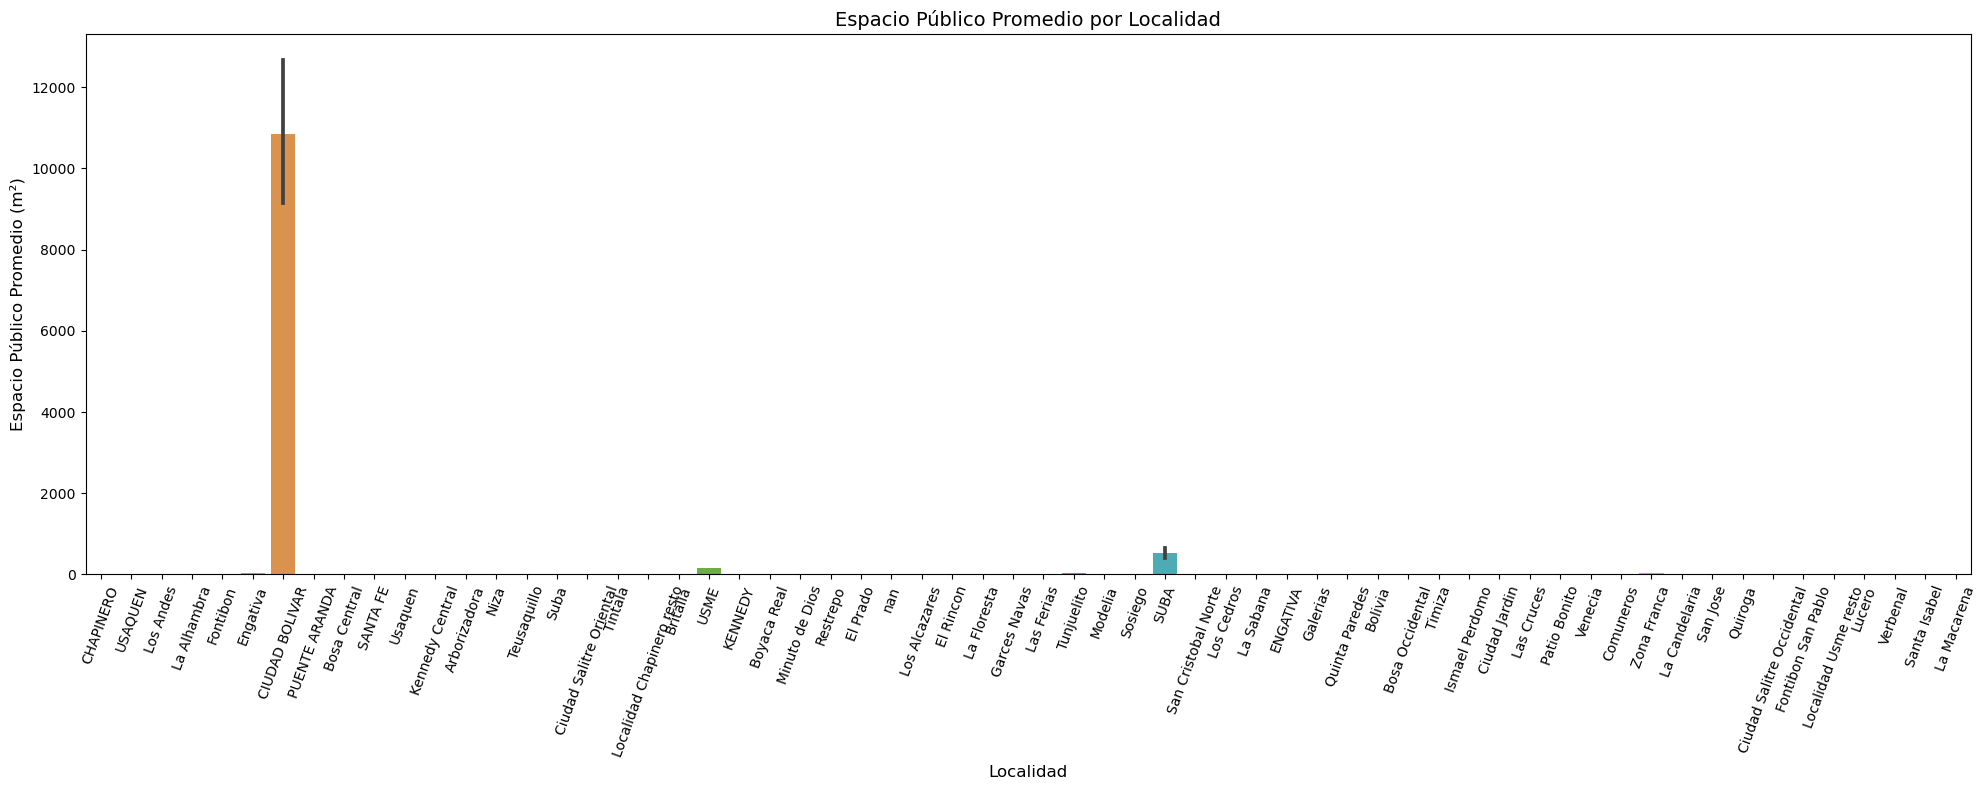

In [20]:
# Convertir las columnas "Valor" y "espacio_en_m2" a tipos numéricos (si aún no lo están)
df_filtrado['Valor'] = df_filtrado['Valor'].astype(float)
df_filtrado['espacio_en_m2'] = df_filtrado['espacio_en_m2'].astype(float)

# Muestra el valor promedio de inmuebles por localidad.
plt.figure(figsize=(20, 8))
sns.barplot(x='localidad', y='Valor', data=df_filtrado)
plt.xticks(rotation=70, fontsize=10)
plt.yticks(fontsize=10)
plt.title('Precio Promedio de Inmuebles por Localidad', fontsize=14)
plt.xlabel('Localidad', fontsize=12)
plt.ylabel('Precio Promedio', fontsize=12)
plt.tight_layout()
plt.show()

# Muestra el espacio público promedio por localidad
plt.figure(figsize=(20, 8))
sns.barplot(x='localidad', y='espacio_en_m2', data=df_filtrado)
plt.xticks(rotation=70, fontsize=10)
plt.yticks(fontsize=10)
plt.title('Espacio Público Promedio por Localidad', fontsize=14)
plt.xlabel('Localidad', fontsize=12)
plt.ylabel('Espacio Público Promedio (m²)', fontsize=12)
plt.tight_layout()
plt.show()

c:\Users\RTOFA2\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


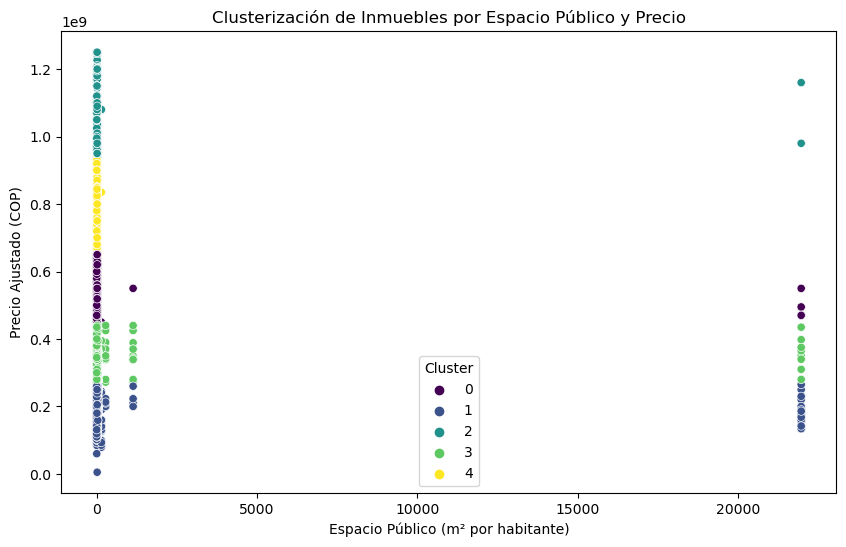

In [21]:
# Imputar valores NaN con la media
X_cluster = df_filtrado[['espacio_en_m2', 'Valor']].fillna(df_filtrado[['espacio_en_m2', 'Valor']].mean())

# KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_cluster)
df_filtrado['cluster'] = kmeans.labels_

# Visualizar los clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtrado, x='espacio_en_m2', y='Valor', hue='cluster', palette='viridis')
plt.title('Clusterización de Inmuebles por Espacio Público y Precio')
plt.xlabel('Espacio Público (m² por habitante)')
plt.ylabel('Precio Ajustado (COP)')
plt.legend(title='Cluster')
plt.show()

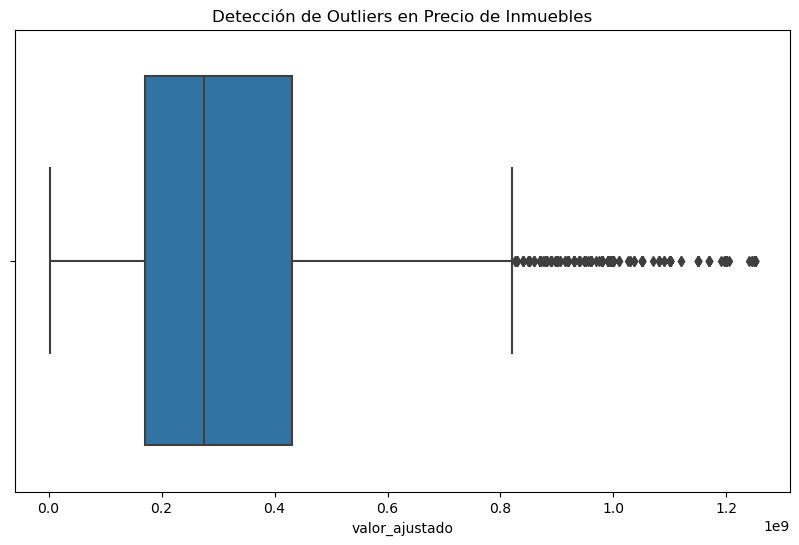

In [17]:
# Analisis de Outliers
# Identificar outliers usando el método IQR
Q1 = df_filtrado['valor_ajustado'].quantile(0.25)
Q3 = df_filtrado['valor_ajustado'].quantile(0.75)
IQR = Q3 - Q1
filtro_outliers = (df_filtrado['valor_ajustado'] < (Q1 - 1.5 * IQR)) | (df_filtrado['valor_ajustado'] > (Q3 + 1.5 * IQR))
outliers = df_filtrado[filtro_outliers]

# Visualizar outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_filtrado['valor_ajustado'])
plt.title('Detección de Outliers en Precio de Inmuebles')
plt.show()


Interpretación de Resultados

In [18]:
# Crear un mapa base de Bogotá
mapa_bogota = folium.Map(location=[4.60971, -74.08175], zoom_start=12)

# Añadiendo marcadores para cada localidad o barrio
for idx, fila in df_filtrado.iterrows():
    if pd.notnull(fila['latitud']) and pd.notnull(fila['longitud']):
        # Informacion para mostrar en el marcador
        popup_text = f"Localidad: {fila['localidad']}<br><br>"
        popup_text += f"Precio: {fila['valor_ajustado']} COP<br><br>"
        popup_text += f"Espacio Público: {fila['espacio_en_m2']} m²<br><br>"
        popup_text += f"Área del Inmueble: {fila['Área']} m²"

        folium.Marker(
            location=[fila['latitud'], fila['longitud']],
            popup=popup_text
        ).add_to(mapa_bogota)
mapa_bogota

In [19]:
# Crear un mapa base de Bogotá
mapa_heatmap = folium.Map(location=[4.60971, -74.08175], zoom_start=12)

# Filtrar filas donde latitud o longitud son NaN
df_filtrado_sin_nan = df_filtrado.dropna(subset=['latitud', 'longitud'])

data_heatmap = df_filtrado_sin_nan[['latitud', 'longitud', 'valor_ajustado']].values.tolist()

HeatMap(data_heatmap, radius=10).add_to(mapa_heatmap)

mapa_heatmap